#Part 1

# Q1. Why does it makes sense to discretize columns for this problem?

Discretizing or binning can help manage the data by grouping it into meaningful ranges while also reducing sensitivity to outliers and noisy thresholds. Discretizing allows the data to be interpreted by users more effectively, which can be used to assess business problems. Discretizing is used to separate zero and non-zero values as well as to group extremely large values meaningfully.



# Q2. What might be the issues (if any) if we DID NOT discretize the columns.

If columns are not discretized, there is a chance for overfitting in the decision trees, splitting the values at very specific thresholds, leading to overly complex decision trees. Without discretizing, the values are harder to interpret in continuous format compared to bins. Not discretizing the columns also leads to instability in the decision tree, with small numeric changes creating different split points in the tree.

In [58]:
# Q1. Why does it makes sense to discretize columns for this problem?
# Discretizing or binning can help manage the data by grouping them into meaningful ranges while also reducing sensitivity to outliers and noisy thresholds.
# Discretizing allows the data to be intrepreted by users more effectively which can be used to assess buisness problems.
# Discretizing is used to separate zero and non-zero values as well as grouping extremely large values meaningfully.


# Q2. What might be the issues (if any) if we DID NOT discretize the columns.
# If columns are not discretized there is a chance for overfitting in the decision trees, splitting the values at very specific thresholds leading to overly complex decision trees.
# Without discretizing, the values are harder to interpret in contiuous format compared to bins.
# Not discretizing the columns also leads to instability in the decision tree with small numeric changes creating different split points in the tree.

In [59]:
# Import neccesary packages
import os, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)

# Load dataset
data = "https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true"
df = pd.read_csv(data)

df.head(3)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0


#Part 2

In [60]:
# Data Quality Report helper
def data_quality_report(data: pd.DataFrame) -> pd.DataFrame:
    dtypes = data.dtypes.astype(str)
    missing = data.isna().sum()
    missing_pct = (100 * missing / len(data)).round(2)
    unique_vals = data.nunique(dropna=False)
    sample = data.head(1).T.iloc[:, 0]
    dqr = pd.DataFrame({
        "dtype": dtypes,
        "missing": missing,
        "missing_%": missing_pct,
        "n_unique": unique_vals,
        "sample_value": sample
    })
    return dqr

print("Rows, Cols:", df.shape)
display(data_quality_report(df))

# Descriptive stats
display(df.describe(include=[np.number]).T)

# Duplicate rows
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")
if dup_count > 0:
    dup_sample = df[df.duplicated()].head(3)
    print("Sample duplicate rows:")
    display(dup_sample)

# Top categories for object-like columns
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    print(f"\n--- {c} (top 10) ---")
    display(df[c].value_counts(dropna=False).head(10))

Rows, Cols: (48842, 11)


,dtype,missing,missing_%,n_unique,sample_value
hours_per_week_bin,object,0,0.0,5,b. 31-40
occupation_bin,object,0,0.0,5,b. Mid - Low
msr_bin,object,0,0.0,3,b. Mid
capital_gl_bin,object,0,0.0,3,c. > 0
race_sex_bin,object,0,0.0,3,c. High
education_num_bin,object,0,0.0,5,c. 13
education_bin,object,0,0.0,5,c. Bachelors
workclass_bin,object,0,0.0,2,b. income
age_bin,object,0,0.0,5,d. 36-40 & 56-60
flag,object,0,0.0,2,train


,count,mean,std,min,25%,50%,75%,max
y,48842.0,0.239282,0.426649,0.0,0.0,0.0,0.0,1.0


Duplicate rows: 40012
Sample duplicate rows:


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
36,b. 31-40,b. Mid - Low,a. Low,a. = 0,c. High,b. 9-12,b. Mid,b. income,a. 0-25,train,0
48,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,0
62,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,0



--- hours_per_week_bin (top 10) ---


,count
hours_per_week_bin,
b. 31-40,26639
d. 41-50 & 61-70,9819
a. 0-30,7851
e. 51-60,3759
c. 71-100,774



--- occupation_bin (top 10) ---


,count
occupation_bin,
c. Mid - Mid,13971
b. Mid - Low,12947
e. High,12258
a. Low,7237
d. Mid - High,2429



--- msr_bin (top 10) ---


,count
msr_bin,
c. High,22047
b. Mid,15868
a. Low,10927



--- capital_gl_bin (top 10) ---


,count
capital_gl_bin,
a. = 0,42525
c. > 0,4035
b. < 0,2282



--- race_sex_bin (top 10) ---


,count
race_sex_bin,
c. High,29737
b. Mid,16457
a. Low,2648



--- education_num_bin (top 10) ---


,count
education_num_bin,
b. 9-12,30324
c. 13,8025
a. 0-8,6408
d. 14,2657
e. 15+,1428



--- education_bin (top 10) ---


,count
education_bin,
b. Mid,30324
c. Bachelors,8025
a. Low,6408
d. Masters,2657
e. High,1428



--- workclass_bin (top 10) ---


,count
workclass_bin,
b. income,46012
a. no income,2830



--- age_bin (top 10) ---


,count
age_bin,
e. 40-55,13963
a. 0-25,9627
c. 31-35 & 61-70,9291
d. 36-40 & 56-60,8927
b. 26-30 & 71-100,7034



--- flag (top 10) ---


,count
flag,
train,32561
test,16281


In [61]:
# Strip whitespace/uniform text for object columns
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

# Guess target and split columns based on common names/patterns used in the assignment
possible_targets = ["income", "Income", "target", "Target", "class", "Class", "income_category", "y"]
possible_splits  = ["split", "Split", "DataSplit", "data_split", "train_test", "TrainTest", "set"]

target_col = next((c for c in possible_targets if c in df.columns), None)
split_col  = next((c for c in possible_splits  if c in df.columns), None)

def find_split_column(d):
    for c in d.columns:
        vals = set(str(v).lower() for v in d[c].dropna().unique())
        if {"train","training"} & vals and {"test","testing"} & vals:
            return c
    return None

if split_col is None:
    split_col = find_split_column(df)

print("Guessed target column:", target_col)
print("Guessed split column:", split_col)

assert target_col is not None, "Please set target_col to the correct target column from your dataset."
assert split_col  is not None, "Please set split_col to the correct train/test column from your dataset."

# Normalize target to 0/1 labels if the file uses <=50K, >50K strings (per brief)
def map_target(y):
    y = y.astype(str).str.strip()
    return y.map({">50K": 1, "<=50K": 0, "1": 1, "0": 0}).astype(int)

df[target_col] = map_target(df[target_col])

df.head(3)

Guessed target column: y
Guessed split column: flag


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0


In [62]:
# Data Quality Report

# Dataset shape: 48842 rows × 11 columns

# Missingness: Zero missing values

# Duplicate rows detected: 40012
# Since there are no unique ID's associated with each row, many rows have duplicate values and fall into the same bins

# Data Cleaning: removing whitespace and normalizing target labels

#Part 3

In [63]:
# Respect the provided split column
train_mask = df[split_col].astype(str).str.lower().isin(["train", "training"])
test_mask  = df[split_col].astype(str).str.lower().isin(["test", "testing"])

train_df = df.loc[train_mask].copy()
test_df  = df.loc[test_mask].copy()

X_train = train_df.drop(columns=[target_col, split_col])
y_train = train_df[target_col].copy()
X_test  = test_df.drop(columns=[target_col, split_col])
y_test  = test_df[target_col].copy()

# Identify column types
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number, "float64", "int64"]).columns.tolist()

# Preprocess: impute + OneHot (safer than label encoding for nominal categories)
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

# Fit on training, transform train and test to numeric matrices for the tree
x_train = preprocess.fit_transform(X_train)
x_test  = preprocess.transform(X_test)

print("Transformed shapes — x_train:", x_train.shape, " x_test:", x_test.shape)


Transformed shapes — x_train: (32561, 36)  x_test: (16281, 36)


In [64]:
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 42

dtree = DecisionTreeClassifier(
    max_depth=10,
    random_state=42,
    max_features=None,
    min_samples_leaf=15
)

dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)

def metrics_dict(y_true, y_pred):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
    }

def fit_and_score(model: DecisionTreeClassifier, verbose=True):
    start = time.time()
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    elapsed = time.time() - start
    y_pred = pipe.predict(X_test)
    m = metrics_dict(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    if verbose:
        print(f"Time: {elapsed:.3f}s | "
              f"Acc: {m['accuracy']:.4f} | Prec: {m['precision']:.4f} | Rec: {m['recall']:.4f} | F1: {m['f1']:.4f}")
        print("Confusion Matrix:\n", cm)
    return pipe, m, cm, elapsed

# Baseline: all defaults, fixed random_state for reproducibility
baseline_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
baseline_pipe, baseline_metrics, baseline_cm, baseline_time = fit_and_score(baseline_model)
baseline_metrics

Time: 0.225s | Acc: 0.8363 | Prec: 0.6918 | Rec: 0.5538 | F1: 0.6152
Confusion Matrix:
 [[11486   949]
 [ 1716  2130]]


{'accuracy': 0.8363122658313371,
 'precision': 0.6917830464436505,
 'recall': 0.5538221528861155,
 'f1': 0.6151624548736462}

#Part 4

Baseline metrics: {'accuracy': 0.8363122658313371, 'precision': 0.6917830464436505, 'recall': 0.5538221528861155, 'f1': 0.6151624548736462}


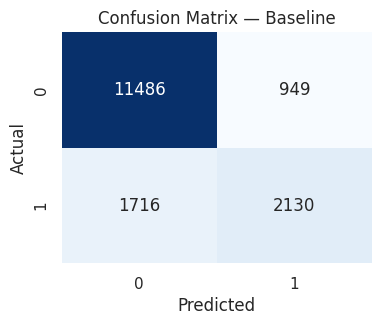


Classification Report — Baseline

              precision    recall  f1-score   support

           0     0.8700    0.9237    0.8960     12435
           1     0.6918    0.5538    0.6152      3846

    accuracy                         0.8363     16281
   macro avg     0.7809    0.7388    0.7556     16281
weighted avg     0.8279    0.8363    0.8297     16281



In [65]:
print("Baseline metrics:", baseline_metrics)
plt.figure(figsize=(4,3))
sns.heatmap(baseline_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix — Baseline")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

print("\nClassification Report — Baseline\n")
print(classification_report(y_test, baseline_pipe.predict(X_test), digits=4))

#Part 5

=== RUN 1 (criterion) ===


,criterion,accuracy,precision,recall,f1
0,gini,0.836312,0.691783,0.553822,0.615162
1,entropy,0.834715,0.685871,0.554082,0.612973


Run 1 winner (by accuracy): gini
=== RUN 2 (min_samples_leaf) ===


,min_samples_leaf,accuracy,precision,recall,f1
0,20,0.844051,0.714755,0.565523,0.631441
1,25,0.843314,0.711532,0.566303,0.630665
2,35,0.843069,0.714096,0.559802,0.627605
3,40,0.842454,0.713287,0.556942,0.625493
4,30,0.842270,0.712434,0.557202,0.625328
5,15,0.841963,0.709582,0.560322,0.626180
6,10,0.839936,0.701560,0.561102,0.623519
7,5,0.838523,0.698015,0.557722,0.620032


Run 2 winner (by accuracy): 20


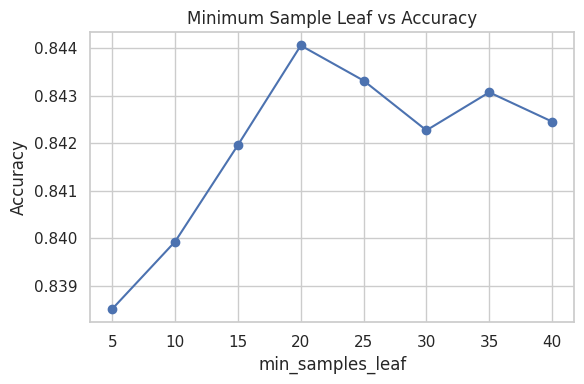

=== RUN 3 (max_features) ===


,max_features,accuracy,precision,recall,f1
0,0.8,0.845341,0.718277,0.568123,0.634437
1,0.5,0.845280,0.718328,0.567603,0.634132
2,None,0.844051,0.714755,0.565523,0.631441
3,0.7,0.843990,0.713259,0.567863,0.632310
4,0.6,0.842024,0.708442,0.562923,0.627354
5,0.4,0.838523,0.696735,0.560322,0.621127
6,0.3,0.837725,0.679380,0.592824,0.633157
7,auto,0.834777,0.680512,0.566563,0.618331


Run 3 winner (by accuracy): 0.8  (used as: 0.8 )


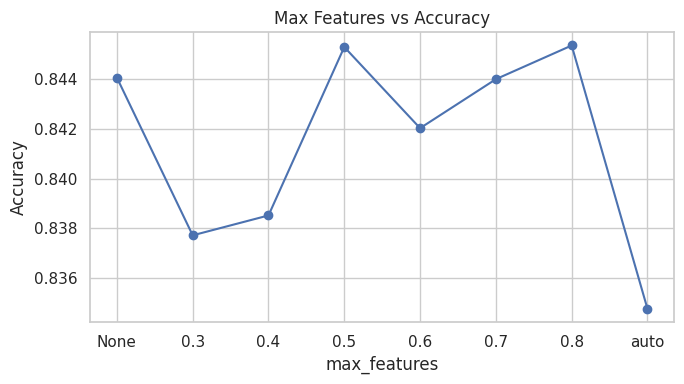

=== RUN 4 (max_depth) ===


,max_depth,accuracy,precision,recall,f1
0,10,0.844113,0.721695,0.553562,0.626545
1,12,0.843744,0.711501,0.569423,0.632582
2,16,0.843683,0.716617,0.559542,0.628413
3,8,0.843437,0.714949,0.560842,0.628588
4,14,0.843437,0.709938,0.570203,0.632444
5,6,0.840366,0.686957,0.595684,0.638073
6,4,0.830723,0.723178,0.459178,0.561705
7,2,0.763774,0.000000,0.000000,0.000000


Run 4 winner (by accuracy): 10


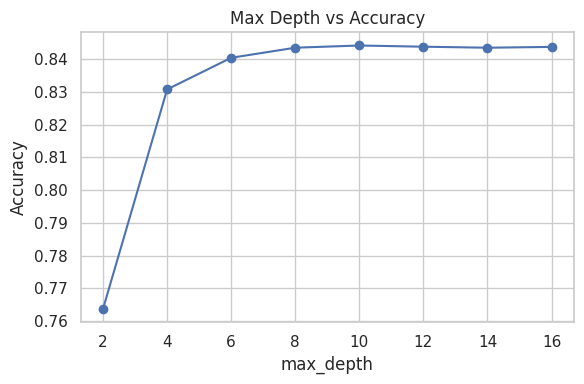

Final BEST params (by test accuracy across runs):


{'criterion': 'gini',
 'min_samples_leaf': 20,
 'max_features': 0.8,
 'max_depth': 10}

In [66]:
# Sequential Hyperparameter Tuning (Runs 1→4)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

sns.set(style="whitegrid", context="notebook")

RANDOM_STATE = 42
SCORING = "accuracy" # primary metric to select the best value per run (per brief)

def eval_metrics(y_true, y_pred):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
    }

def train_eval_once(params, x_train, y_train, x_test, y_test):
    """Train DecisionTreeClassifier with given params; return metrics + model."""
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, **params)
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)
    return {**eval_metrics(y_test, y_hat), "model": model}

def sweep_one(param_name, values, base_params):
    """
    Vary a single hyperparameter given the current best base_params.
    Returns: (df_sorted_by_accuracy_desc, best_value, best_metrics_dict)
    """
    rows = []
    for v in values:
        params = base_params.copy()
        params[param_name] = v
        metrics = train_eval_once(params, x_train, y_train, x_test, y_test)
        rows.append({param_name: v, **{k: val for k, val in metrics.items() if k != "model"}})
    df = pd.DataFrame(rows).sort_values("accuracy", ascending=False).reset_index(drop=True)
    winner_value = df.iloc[0][param_name]
    winner_metrics = df.iloc[0].to_dict()
    return df, winner_value, winner_metrics

def lineplot(x_vals, y_vals, title, x_label):
    plt.figure(figsize=(6,4))
    plt.plot(x_vals, y_vals, marker="o")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Run 1 — Split Criterion


# Keep all other params at defaults; test 'gini' vs 'entropy'
run1_values = ["gini", "entropy"]
base_params = {}
r1_df, best_criterion, _ = sweep_one("criterion", run1_values, base_params)
print("=== RUN 1 (criterion) ===")
display(r1_df)
print("Run 1 winner (by accuracy):", best_criterion)


# Run 2 — min_samples_leaf


# Carry forward best criterion; vary min_samples_leaf per your table
run2_values = [5, 10, 15, 20, 25, 30, 35, 40]
base_params = {"criterion": best_criterion}
r2_df, best_leaf, _ = sweep_one("min_samples_leaf", run2_values, base_params)
print("=== RUN 2 (min_samples_leaf) ===")
display(r2_df)
print("Run 2 winner (by accuracy):", int(best_leaf))

# Plot: min_samples_leaf vs accuracy
lineplot(
    x_vals=[row["min_samples_leaf"] for _, row in r2_df.sort_values("min_samples_leaf").iterrows()],
    y_vals=[row["accuracy"] for _, row in r2_df.sort_values("min_samples_leaf").iterrows()],
    title="Minimum Sample Leaf vs Accuracy",
    x_label="min_samples_leaf"
)


# Run 3 — max_features


# Carry forward best criterion + min_samples_leaf; vary max_features
# Your table shows None and fractions (0.3→0.8) plus 'auto'. Map 'auto'→'sqrt' for compatibility.
def normalize_max_features(v):
    return "sqrt" if v == "auto" else v

run3_values_display = [None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, "auto"]  # display values
run3_values_used    = [normalize_max_features(v) for v in run3_values_display]

base_params = {"criterion": best_criterion, "min_samples_leaf": int(best_leaf)}
# Build rows preserving the display value
rows_r3 = []
for disp_val, used_val in zip(run3_values_display, run3_values_used):
    params = base_params.copy()
    params["max_features"] = used_val
    metrics = train_eval_once(params, x_train, y_train, x_test, y_test)
    rows_r3.append({"max_features": disp_val, **{k: val for k, val in metrics.items() if k != "model"}})

r3_df = pd.DataFrame(rows_r3).sort_values("accuracy", ascending=False).reset_index(drop=True)
best_mf_display = r3_df.iloc[0]["max_features"]
best_mf_used = normalize_max_features(best_mf_display)

print("=== RUN 3 (max_features) ===")
display(r3_df)
print("Run 3 winner (by accuracy):", best_mf_display, " (used as:", best_mf_used, ")")

# Plot: max_features vs accuracy
plt.figure(figsize=(7,4))
plt.plot(range(len(rows_r3)), [row["accuracy"] for row in rows_r3], marker="o")
plt.xticks(range(len(rows_r3)), [str(row["max_features"]) for row in rows_r3])
plt.title("Max Features vs Accuracy")
plt.xlabel("max_features"); plt.ylabel("Accuracy")
plt.grid(True); plt.tight_layout(); plt.show()


# Run 4 — max_depth


# Carry forward best criterion + min_samples_leaf + max_features; vary max_depth
run4_values = [2, 4, 6, 8, 10, 12, 14, 16]
base_params = {"criterion": best_criterion,
               "min_samples_leaf": int(best_leaf),
               "max_features": best_mf_used}


# Now compute the full metrics table (accuracy, precision, recall, f1)
rows_r4 = []
for depth in run4_values:
    params = base_params.copy()
    params["max_depth"] = depth
    metrics = train_eval_once(params, x_train, y_train, x_test, y_test)
    rows_r4.append({"max_depth": depth, **{k: val for k, val in metrics.items() if k != "model"}})

r4_df = pd.DataFrame(rows_r4).sort_values("accuracy", ascending=False).reset_index(drop=True)
best_depth = int(r4_df.iloc[0]["max_depth"])

print("=== RUN 4 (max_depth) ===")
display(r4_df)
print("Run 4 winner (by accuracy):", best_depth)

# Plot: max_depth vs accuracy
lineplot(
    x_vals=[row["max_depth"] for _, row in r4_df.sort_values("max_depth").iterrows()],
    y_vals=[row["accuracy"] for _, row in r4_df.sort_values("max_depth").iterrows()],
    title="Max Depth vs Accuracy",
    x_label="max_depth"
)


# Final chosen hyperparameters after Runs 1→4


best_params = {
    "criterion": best_criterion,
    "min_samples_leaf": int(best_leaf),
    "max_features": best_mf_used,
    "max_depth": best_depth
}
print("Final BEST params (by test accuracy across runs):")
best_params


#Question 3
The best model by accuracy is [criteria: gini, sample leaf: 20, features: 0.8, depth: 10]


#Part 6

BEST model hyperparameters: {'criterion': 'gini', 'min_samples_leaf': 20, 'max_features': 0.8, 'max_depth': 10} 

Confusion Matrix (labels: 0=<=50K, 1=>50K)
[[11614   821]
 [ 1717  2129]]

TN=11614, FP=821, FN=1717, TP=2129

Metrics (Test):
Accuracy : 0.8441
Precision: 0.7217
Recall   : 0.5536
F1 Score : 0.6265

Classification Report:
              precision    recall  f1-score   support

       <=50K     0.8712    0.9340    0.9015     12435
        >50K     0.7217    0.5536    0.6265      3846

    accuracy                         0.8441     16281
   macro avg     0.7964    0.7438    0.7640     16281
weighted avg     0.8359    0.8441    0.8365     16281



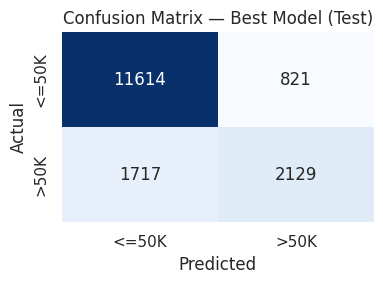

In [67]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---- Safety checks ----
assert 'best_params' in globals() and isinstance(best_params, dict), "Run the tuning loop first to populate best_params."
assert all(k in best_params for k in ["criterion","min_samples_leaf","max_features","max_depth"]), "best_params missing expected keys."

# ---- Train BEST model ----
best_model = DecisionTreeClassifier(random_state=42, **best_params)
best_model.fit(x_train, y_train)

# ---- Evaluate ----
y_pred_best = best_model.predict(x_test)

cm = confusion_matrix(y_test, y_pred_best, labels=[0,1])
TN, FP, FN, TP = cm.ravel()

acc  = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best, zero_division=0)
rec  = recall_score(y_test, y_pred_best, zero_division=0)
f1   = f1_score(y_test, y_pred_best, zero_division=0)

print("BEST model hyperparameters:", best_params, "\n")

print("Confusion Matrix (labels: 0=<=50K, 1=>50K)")
print(cm)
print(f"\nTN={TN}, FP={FP}, FN={FN}, TP={TP}")

print("\nMetrics (Test):")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['<=50K','>50K'], digits=4))

# Confusion matrix heatmap
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['<=50K','>50K'], yticklabels=['<=50K','>50K'])
plt.title("Confusion Matrix — Best Model (Test)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

In [68]:
# Rebuild the feature names that the tree actually saw (numeric + one-hot categorical)
# Requires your fitted 'preprocess', and lists 'num_cols' and 'cat_cols' from Part 3.
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(cat_feature_names)

print("Feature count used by the tree:", len(feature_names))

Feature count used by the tree: 36


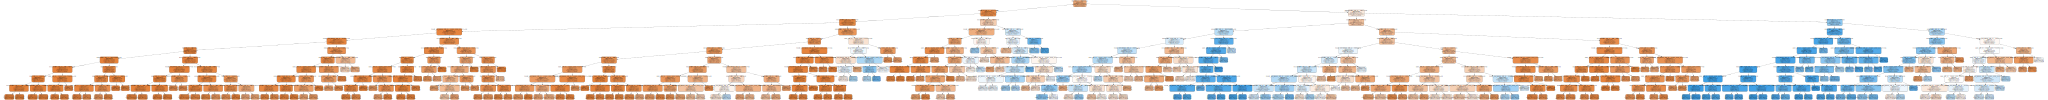

In [69]:
# Try to use GraphViz (recommended). If unavailable, fall back to matplotlib.
try:
    import graphviz
    from sklearn.tree import export_graphviz
    GRAPHVIZ_AVAILABLE = True
except Exception:
    GRAPHVIZ_AVAILABLE = False

if GRAPHVIZ_AVAILABLE:
    # Sanitize feature names for Graphviz to avoid special character issues
    sanitized_feature_names = []
    for name in feature_names:
        # Replace problematic characters for DOT format
        sanitized_name = name.replace('.', '_').replace(' ', '_').replace('&', 'and').replace('>', 'gt').replace('<', 'lt')
        sanitized_feature_names.append(sanitized_name)

    # Render top levels in-notebook
    dot = export_graphviz(
        best_model,
        out_file=None,
        feature_names=sanitized_feature_names, # Use sanitized names here
        class_names=["<=50K", ">50K"],
        filled=True, rounded=True,
        max_depth=10   # show only top of the tree for readability
    )
    graph = graphviz.Source(dot)
    display(graph)
else:
    print("GraphViz not available; showing matplotlib snapshot of top of the tree.")
    plt.figure(figsize=(22, 10))
    plot_tree(
        best_model,
        feature_names=feature_names,
        class_names=["<=50K", ">50K"],
        filled=True,
        max_depth=10
    )
    plt.show()

#Part 7

In [73]:

def overfit_comment(max_depth, min_samples_leaf):
    risks = []
    if (max_depth is None) or (isinstance(max_depth, (int, float)) and max_depth >= 25):
        risks.append("very deep (or unbounded) depth can memorize noise")
    if min_samples_leaf <= 2:
        risks.append("very small leaf size tends to overfit")
    if not risks:
        return "Depth and leaf size suggest reasonable regularization; overfitting risk appears controlled."
    return "Potential overfitting risk because " + " and ".join(risks) + "."

print({overfit_comment(best_params['max_depth'], best_params['min_samples_leaf'])})

{'Depth and leaf size suggest reasonable regularization; overfitting risk appears controlled.'}


#Q.4 How long was your total run time to train the best model?
It took around 8-10 seconds of runtime to train the best model.

#Q.5 Did you find the BEST TREE?
Yes, using the accuracy of each run we were able to determine the best tree.

#Q.6 Write your observations from the visualization of the best tree
The top splits of the tree highlight the most discriminate features at the root. The paths seperate the population into groups with different income likelihoods.

#Q.7 Will this Tree “overfit”?
The tree is not overfit and appears to be controlled with reasonable regularization.

#Part 8

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Safety checks
assert 'preprocess' in globals(), "Expected a fitted 'preprocess' from Part 3."
assert 'X_train' in globals() and 'y_train' in globals(), "Need pre-encoded training data: X_train, y_train." # Updated assertion
assert 'best_params' in globals() and isinstance(best_params, dict), "Run Part 5 to populate best_params."

best_pipe = Pipeline(steps=[
    ("prep", preprocess),  # same binning/encoding as training
    ("model", DecisionTreeClassifier(random_state=42, **best_params))
])

# Fit pipeline on raw training features
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['hours_per_week_bin',
                                                   'occupation_bin', 'msr_bin',
                                                   'capital_gl_bin',
                                                   'race_sex_bin',
                                                   'education_num_bin',
                                                   'education_bin',
                                                   'workclass_bin',
                                                   'age_bin'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=10, max_features=0.8,
                                        min_samples_leaf=20,
                                        random_state=42))])

In [72]:
import pandas as pd

# Inspect your actual training column names to ensure the keys below are correct
print("Sample of training feature columns:", list(X_train.columns)[:15])

# Values should also be in the binned format used by the model.
new_person = {
    "hours_per_week_bin": "b. 31-40",
    "occupation_bin": "b. Mid - Low",
    "msr_bin": "c. High",
    "capital_gl_bin": "c. > 0",
    "race_sex_bin": "c. High",
    "education_num_bin": "b. 9-12",
    "education_bin": "b. Mid",
    "workclass_bin": "b. income",
    "age_bin": "d. 36-40 & 56-60"
}

# Alignment checks
missing = set(X_train.columns) - set(new_person.keys())
extra   = set(new_person.keys()) - set(X_train.columns)
if missing:
    print("WARNING — The following columns are missing in new_person:", missing)
if extra:
    print("NOTE — The following keys are extra and will be ignored when we subset:", extra)

# Build one-row DataFrame in the exact training column order
new_person_df = pd.DataFrame([new_person])[X_train.columns]

# Predict class and probability
pred_class = best_pipe.predict(new_person_df)[0]
proba = best_pipe.predict_proba(new_person_df)[0]   # [P(<=50K), P(>50K)]

pred_label = ">50K" if pred_class == 1 else "<=50K"
pred_prob  = proba[pred_class]  # probability of the predicted class

print(f"Predicted Income Category: {pred_label}")
print(f"Probability (model confidence): {pred_prob:.4f}")

Sample of training feature columns: ['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin', 'education_bin', 'workclass_bin', 'age_bin']
Predicted Income Category: >50K
Probability (model confidence): 0.7114


#Q.8 What is the probability that your prediction for this person is correct?
The model assigns 71.14% probability to the predicted class (>50K). This represents the model’s confidence, not guaranteed correctness.